- Code ref: https://github.com/scikit-signal/pytftb/blob/master/tftb/processing/ambiguity.py
- Gallery of examples: http://pytftb.readthedocs.io/en/master/auto_examples/

In [ ]:
import scipy
from scipy.signal import hamming
import statsmodels
from tftb.generators import altes, amgauss, fmlin
from tftb.processing import Spectrogram, WignerVilleDistribution
from tftb.processing.ambiguity import narrow_band, wide_band

figsize('inline');

In [ ]:
# TODO TODO pytftb seems very slow -- can we do it faster by hand, by using numpy/scipy ops instead of python loops?
def plot_ambiguity_comparison(
    x,
    spec_timestamps=None,  # Default: np.arange(len(x))
    spec_n_fbins=None,  # Default: len(x)
    spec_fwindow=None,  # Default: hamming(len(x) // 4)
    spec_plot_kind='cmap',
    spec_plot_threshold=0,
    wvd_plot_kind='cmap',
    narrow_band_lag=None,
    narrow_band_n_fbins=None,
    wide_band_fmin=None,
    wide_band_fmax=None,
    wide_band_N=None,
    # TODO **1 vs. **2? pytftb examples used **2, but I "see more" with **1, and Spectrogram.plot forces sqmod=False...
    sqmod=False,
):

    af_pow = 2 if sqmod else 1

    plt.subplot(231)
    plt.title('Signal')
    plt.plot(x)
    plt.xlabel('time')
    plt.ylabel('amp')

    plt.subplot(232)
    spec = Spectrogram(x, timestamps=spec_timestamps, n_fbins=spec_n_fbins, fwindow=spec_fwindow)
    spec.run()
    spec.plot(ax=plt.gca(), show=False, show_tf=False, kind=spec_plot_kind, threshold=spec_plot_threshold)
    plt.title('Spectrogram')  # After spec.plot
    plt.xlabel('time')
    plt.ylabel('freq (normalized)')

    plt.subplot(233)
    wvd = WignerVilleDistribution(x, timestamps=spec_timestamps, n_fbins=spec_n_fbins, fwindow=spec_fwindow)
    wvd.run()
    wvd.plot(ax=plt.gca(), show=False, show_tf=False, kind=wvd_plot_kind)
    plt.title('WVD')  # After wvd.plot
    plt.xlabel('time')
    plt.ylabel('freq (normalized)')

    plt.subplot(235)
    plt.title('Narrow-band ambiguity')
    naf, lag, doppler = narrow_band(x, lag=narrow_band_lag, n_fbins=narrow_band_n_fbins)
    plt.pcolormesh(lag, doppler, np.abs(naf) ** (2 if sqmod else 1))
    plt.xlabel('lag')
    plt.ylabel('doppler')
    ax_naf = plt.gca()

    plt.subplot(236)
    plt.title('Wide-band ambiguity')
    waf, lag, doppler = wide_band(x, fmin=wide_band_fmin, fmax=wide_band_fmax, N=wide_band_N)
    plt.pcolormesh(lag, doppler, np.abs(waf) ** (2 if sqmod else 1))
    plt.xlabel('lag')
    plt.ylabel('doppler')
    ax_waf = plt.gca()

    # Match lims across narrow/wide-band plots
    axes = [ax_naf, ax_waf]
    xlim = [min(ax.get_xlim()[0] for ax in axes), max(ax.get_xlim()[1] for ax in axes)]
    ylim = [min(ax.get_ylim()[0] for ax in axes), max(ax.get_ylim()[1] for ax in axes)]
    for ax in axes:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()

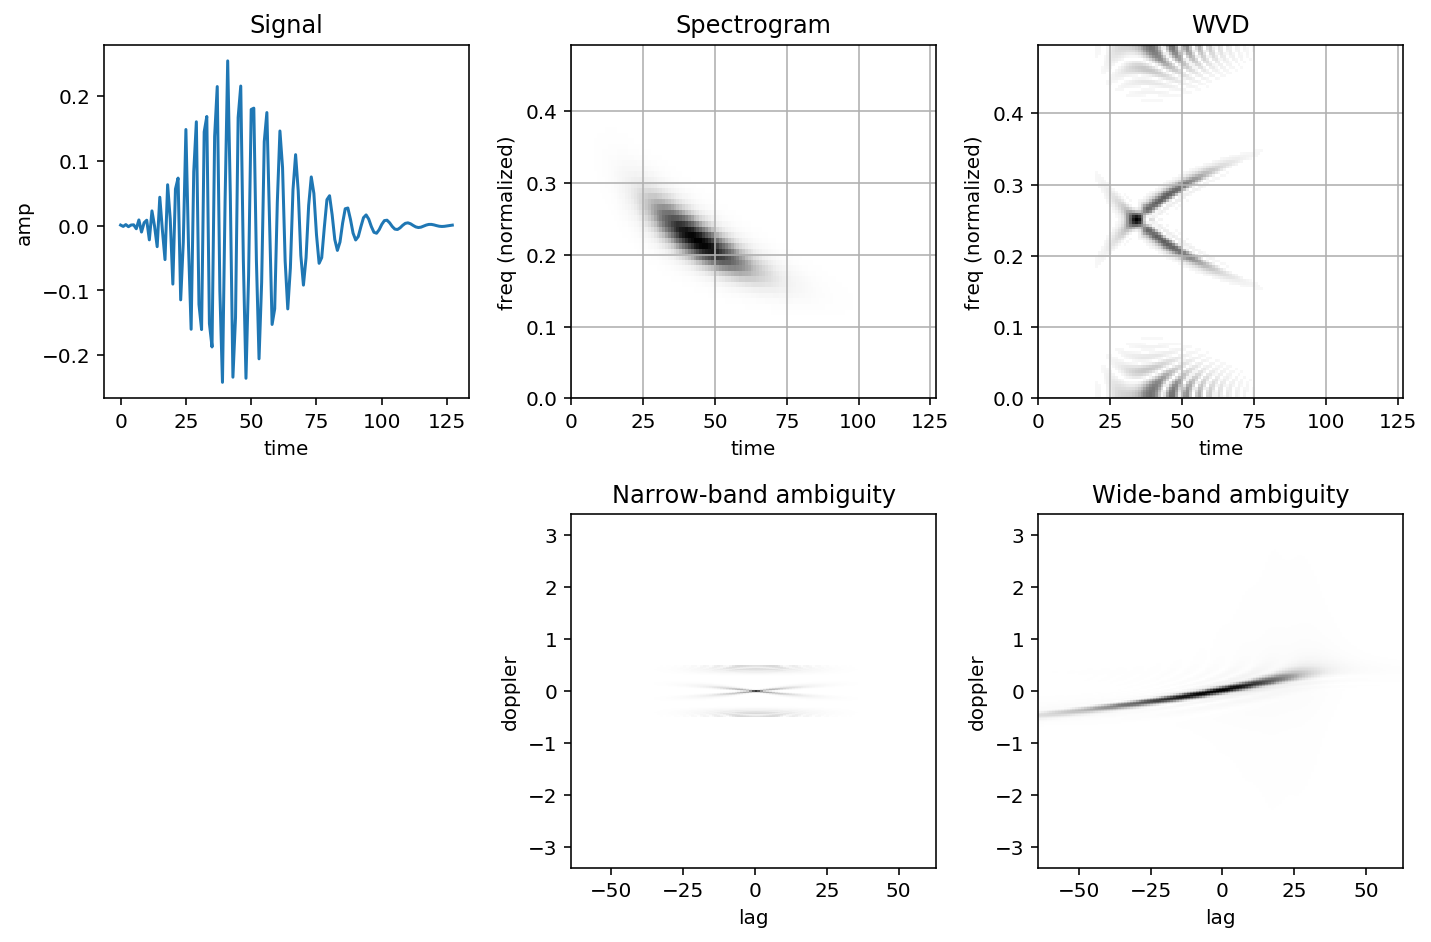

In [ ]:
x = altes(128, 0.1, 0.45)
plot_ambiguity_comparison(x)

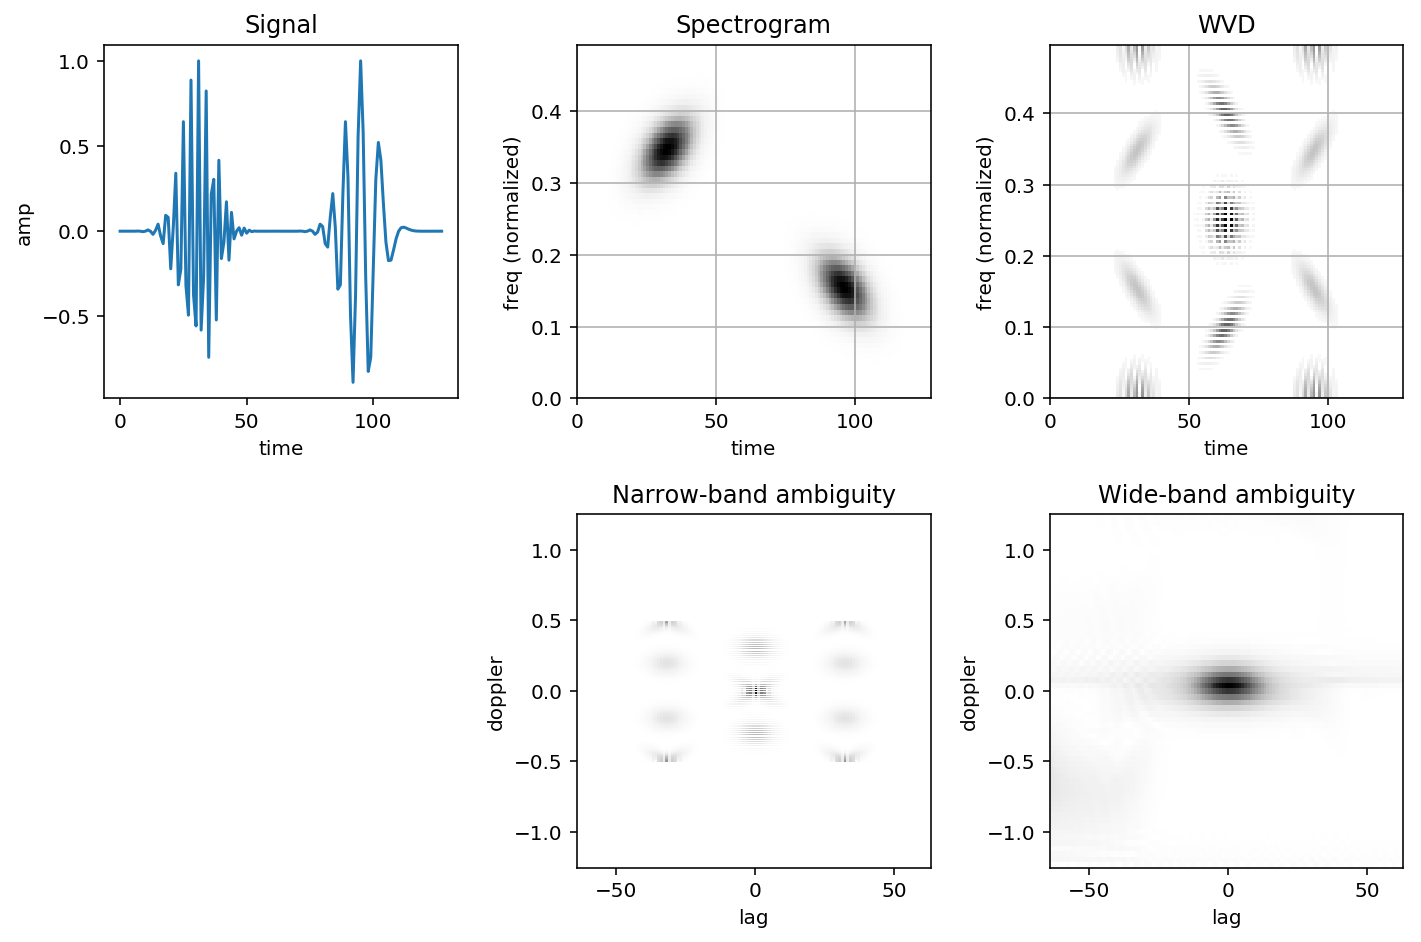

In [ ]:
n = 64
x = np.hstack((
    np.real(fmlin(n, 0.2, 0.5)[0] * amgauss(n)),
    np.real(fmlin(n, 0.3, 0)[0] * amgauss(n)),
))
plot_ambiguity_comparison(x)

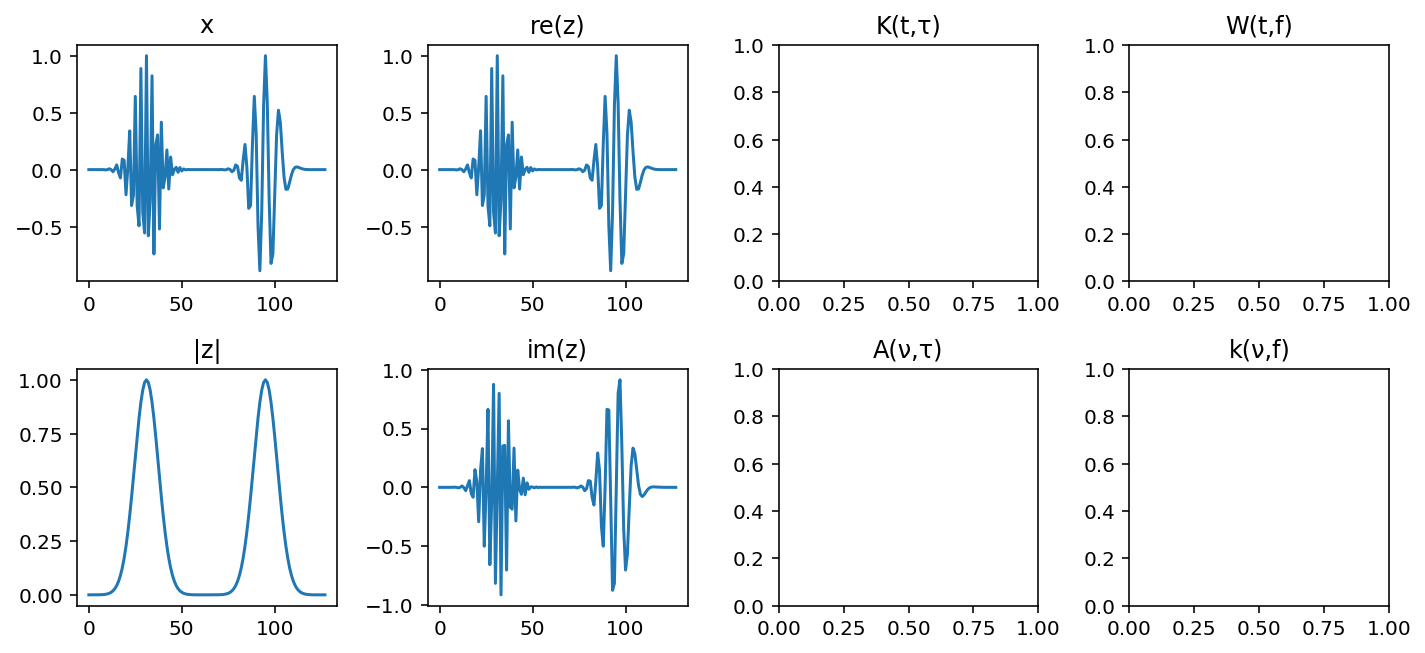

In [ ]:
# TODO TODO Try buiding (K,A,W,k) ourselves -- all we should need is numpy/scipy correlate and fft...

plt.subplot(341)
plt.title('x')
n = 64
x = np.hstack((
    np.real(fmlin(n, 0.2, 0.5)[0] * amgauss(n)),
    np.real(fmlin(n, 0.3, 0)[0] * amgauss(n)),
))
plt.plot(x)

z = scipy.signal.hilbert(x)
plt.subplot(342)
plt.title('re(z)')
plt.plot(z.real)
plt.subplot(345)
plt.title('|z|')
plt.plot(np.abs(z))
plt.subplot(346)
plt.title('im(z)')
plt.plot(z.imag)

plt.subplot(343)
plt.title('K(t,τ)')
# TODO TODO How to compute ACF? In a not-slow way?

plt.subplot(344)
plt.title('W(t,f)')

plt.subplot(347)
plt.title('A(ν,τ)')

plt.subplot(348)
plt.title('k(ν,f)')

plt.tight_layout()
plt.show()

In [ ]:
# Timing
#   correlate iter, no K=np.array, no plot
#             n  O(n^2)     O(n)/correlate
#       128*400      ?s   5.00ms/correlate
#       128*200      ?s   2.50ms/correlate
#       128*100   17.0s   1.30ms/correlate
#       128*50     4.4s    .68ms/correlate
#       128*25     1.2s    .37ms/correlate
x = altes(128*400, 0.1, 0.45)
# with with_figsize('inline_short'):
#     plt.plot(x)
#     plt.show()
# TODO TODO This seems too slow... but aren't we doing too much work?? See audio.spectrogram, to the left...
display(x.shape)
# %time K = np.array([scipy.signal.correlate(x + tau/2, x - tau/2) for tau in range(len(x))])  # XXX Wrong math
# %time for _ in (scipy.signal.correlate(x + tau/2, x - tau/2) for tau in range(len(x))): pass  # XXX Wrong math
# %timeit [scipy.signal.correlate(x + tau/2, x - tau/2) for tau in [10]]  # XXX Wrong math
# display(K.shape)

(51200, )

5.03 ms ± 95.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# TODO TODO I only care about this PWVD insofar as it helps me write my own (K,A,W,k) transforms
def PWVD(
    x,  # A real signal
    t=None,  # The time offsets of each sample in x (default: range(len(x)))
):
    """
    Pseudo WVD (PWVD)
    - Code based on: https://zenodo.org/record/183985 [TODO MIT license]
    - Math something like: https://en.wikipedia.org/wiki/Modified_Wigner_distribution_function
    """
    pass

In [ ]:
# TODO TODO Half-baked, shifted focus to writing (K,A,W,k) ourselves, above
x = altes(128, 0.1, 0.45)
t = range(len(x))
t_step = t[1] - t[0]

# Let z be the analytic associate of x
z = scipy.signal.hilbert(x)

# Let K be the IAF (instantaneous autocorrelation function) of z
zpad = np.append(np.zeros_like(z), z)
K = np.array(dtype=complex, object=[
    # XXX Use scipy.signal.correlate instead of doing this inner loop ourselves (and kill zpad)
    #   - TODO Actually, is correlate the wrong function...? (derp)
    [zpad[ti + tau] * np.conjugate(zpad[ti - tau]) for tau in range(-len(z) + 1, len(z) + 1)]
    for ti in range(0, len(t))
])
display(
    z.shape,
    scipy.signal.correlate(z, z).shape,
    K.shape,
)
with with_figsize('inline_short'):
    plt.plot(np.abs(z)); plt.show()
    plt.pcolormesh(np.abs(K)); plt.show()

In [ ]:
fft_matrix = []
freq_matrix = []
for row in K:
    n = len(row)
    fft_matrix.append(np.fft.fft(row, norm='ortho')[0 : n // 2])
    freq_matrix.append(np.fft.fftfreq(n, d=t_step)[0 : n // 2])

pwvd = np.real(fft_matrix)  # .T?
f = np.array(freq_matrix[0]) * 0.5

plt.pcolormesh(t, f, pwvd)